In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-01-10 12:02:21.645487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 12:02:21.645521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 12:02:21.646782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 12:02:21.653073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 12:02:22.701559: W tensorflow/compiler/tf2

# 各パス指定

In [2]:
dataset = 'model/two_hands_keypoint_classifier/two_hands_keypoint.csv'
model_save_path = 'model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 5

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2 * 2, )),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                6800      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                2

In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


18/24 [=====================>........] - ETA: 0s - loss: 1.4639 - accuracy: 0.3346 
Epoch 1: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
24/24 [==============================] - 2s 22ms/step - loss: 1.4255 - accuracy: 0.3470 - val_loss: 1.2207 - val_accuracy: 0.4550
Epoch 2/1000
15/24 [=================>............] - ETA: 0s - loss: 1.1629 - accuracy: 0.4771
Epoch 2: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5


/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 9ms/step - loss: 1.1089 - accuracy: 0.5053 - val_loss: 0.8180 - val_accuracy: 0.6970
Epoch 3/1000
13/24 [===============>..............] - ETA: 0s - loss: 0.8426 - accuracy: 0.6466
Epoch 3: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
24/24 [==============================] - 0s 8ms/step - loss: 0.7966 - accuracy: 0.6673 - val_loss: 0.5278 - val_accuracy: 0.8260
Epoch 4/1000
14/24 [================>.............] - ETA: 0s - loss: 0.6238 - accuracy: 0.7427
Epoch 4: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
24/24 [==============================] - 0s 10ms/step - loss: 0.5950 - accuracy: 0.7530 - val_loss: 0.3623 - val_accuracy: 0.8650
Epoch 5/1000
15/24 [=================>............] - ETA: 0s - loss: 0.4733 - accuracy: 0.8016
Epoch 5: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
24/24 [=============================

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.9970


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 107ms/step
[5.1718654e-08 9.9999750e-01 2.4847989e-06 9.0764243e-11 7.2476491e-09]
1


# 混同行列

32/32 [==============================] - 0s 1ms/step


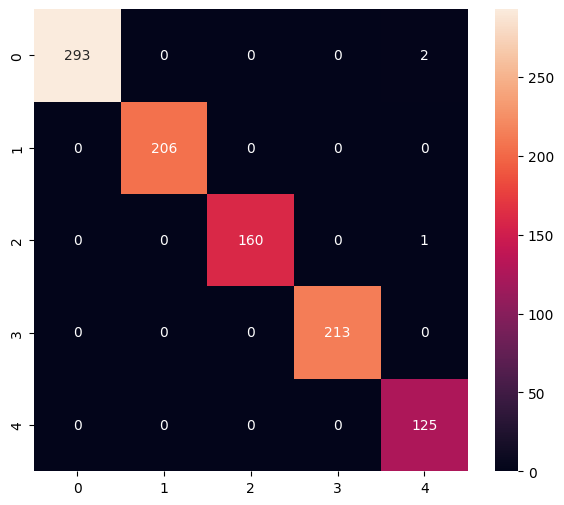

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       295
           1       1.00      1.00      1.00       206
           2       1.00      0.99      1.00       161
           3       1.00      1.00      1.00       213
           4       0.98      1.00      0.99       125

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpw8hzi85m/assets


INFO:tensorflow:Assets written to: /tmp/tmpw8hzi85m/assets
2024-01-10 12:02:40.379965: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-10 12:02:40.379992: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-10 12:02:40.380296: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpw8hzi85m
2024-01-10 12:02:40.382117: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-10 12:02:40.382129: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpw8hzi85m
2024-01-10 12:02:40.385392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-10 12:02:40.388719: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-10 12:02:40.447027: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

17776

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 397 µs, sys: 52 µs, total: 449 µs
Wall time: 372 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.1789527e-08 9.9999750e-01 2.4446829e-06 8.9107749e-11 7.1883814e-09]
1
